Potrebni paketi (biblioteke)

In [1]:
import numpy as np
import tenseal as ts
import pandas as pd
import math
import matplotlib.pyplot as plt
import time
import gc

Učitavanje podataka

In [2]:
fp_organizer = "/home/jovyan/work/organizer.xlsx" 
fp_participant1 = "/home/jovyan/work/participant1.xlsx"
fp_participant2 = "/home/jovyan/work/participant2.xlsx" 
fp_participant3 = "/home/jovyan/work/participant3.xlsx"

# Naponi
Un = 230  # nazivni napon
Umj = 110  # mjerni napon

k = (Un / Umj) ** 2

try:
    df_org = pd.read_excel(fp_organizer, skiprows=[1])
    df_p1 = pd.read_excel(fp_participant1, skiprows=[1])
    df_p2 = pd.read_excel(fp_participant2, skiprows=[1])
    df_p3 = pd.read_excel(fp_participant3, skiprows=[1])
    
    df_org["M [Nm]"] = df_org["M [Nm]"] * k
    df_p1["M [Nm]"] = df_p1["M [Nm]"] * k
    df_p2["M [Nm]"] = df_p2["M [Nm]"] * k
    df_p3["M [Nm]"] = df_p3["M [Nm]"] * k

except Exception as e:
    print(f"Greška: {e}")

Prikaz raspodjele koraka brzine

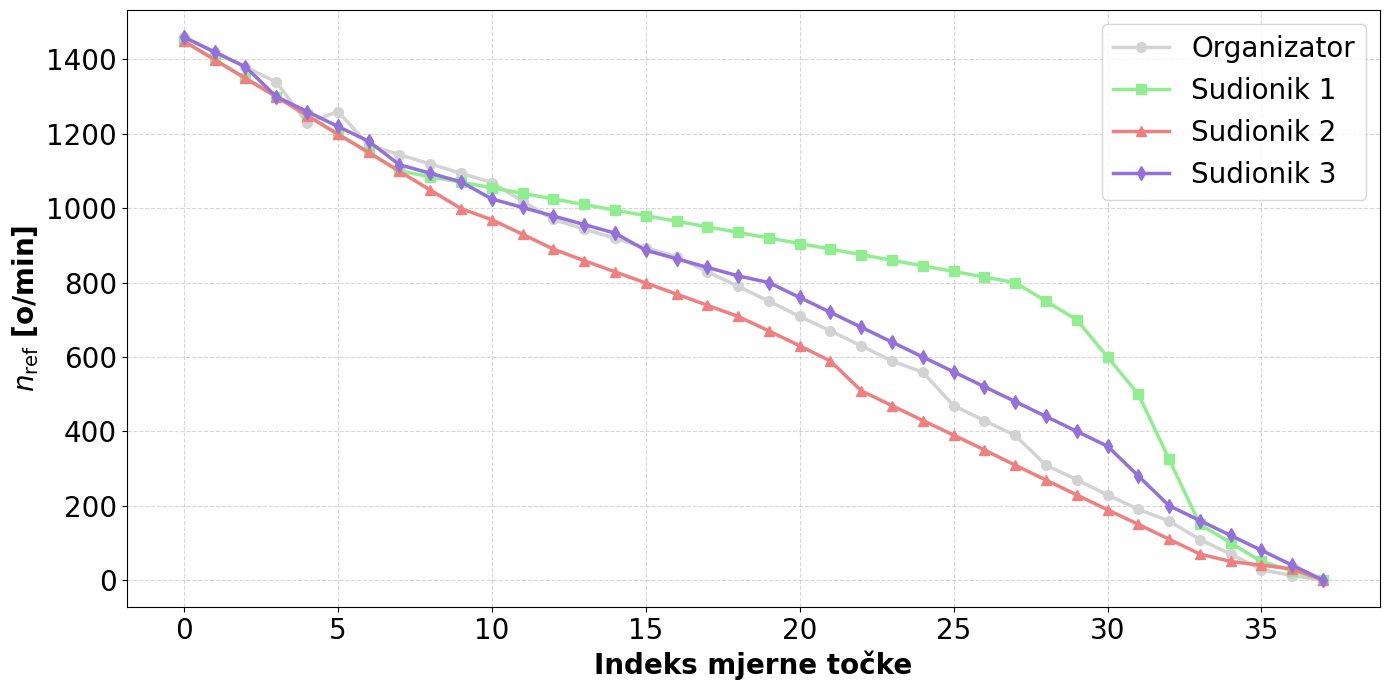

In [3]:
nref_org = df_org["nref (o/min)"]
nref_p1 = df_p1["nref_o_min_"]
nref_p2 = df_p2["n [o/min]"]
nref_p3 = df_p3["n [o/min]"]

x = list(range(len(nref_org)))

plt.figure(figsize=(14, 7))

plt.plot(x, nref_org, marker='o', markersize=7, linewidth=2.5, color='lightgrey', label='Organizator')
plt.plot(x, nref_p1, marker='s', markersize=7, linewidth=2.5, color='lightgreen', label='Sudionik 1')
plt.plot(x, nref_p2, marker='^', markersize=7, linewidth=2.5, color='lightcoral', label='Sudionik 2')
plt.plot(x, nref_p3, marker='d', markersize=7, linewidth=2.5, color='mediumpurple', label='Sudionik 3')

plt.xlabel('Indeks mjerne točke', fontsize=20, fontweight='bold')
plt.ylabel(r'$n_{\mathrm{ref}}$ [o/min]', fontsize=20, fontweight='bold')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.legend(fontsize=20, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("diff_nref.png", dpi=300, bbox_inches='tight')
plt.show()

Definiranje konteksta i generiranje ključeva

In [4]:
%%time
poly_mod_degree = 16384
coeff_mod_bit_sizes = [50, 40, 40, 40, 40, 40, 40, 40, 40, 50]
scale = 2**40

context = ts.context(
    scheme=ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=poly_mod_degree,
    coeff_mod_bit_sizes=coeff_mod_bit_sizes,
)

context.global_scale = scale

context.generate_galois_keys()
context.generate_relin_keys()

public_context = context.copy() 
public_context.make_context_public()

with open("tenseal_public.ckks", "wb") as f:
    f.write(public_context.serialize())

with open("tenseal_private.ckks", "wb") as f:
    f.write(context.serialize())

print("CKKS kontekst i ključevi su generirani.")

CKKS kontekst i ključevi su generirani.
CPU times: user 18.8 s, sys: 6.41 s, total: 25.2 s
Wall time: 25.1 s


Predobrada podataka

In [5]:
U_B = 0.277
k = 2  
def preprocessing(column_H):
    podaci = column_H.to_numpy()
    m = len(podaci)
    
    Xm = np.mean(podaci)
    sigma = np.sqrt(np.sum((podaci - Xm) ** 2) / m)
    sigma_inverse = 1 / sigma if sigma != 0 else np.inf 
    U_A = sigma / np.sqrt(m)
    U = k * np.sqrt(U_A**2 + U_B**2)
    U_squared = U**2

    return {
        "Xm": Xm,
        "σ": sigma,
        "σ_inverse": sigma_inverse,
        "U_A": U_A,
        "U": U,
        "U_squared": U_squared
    }

rezultati_p1 = preprocessing(df_p1["M [Nm]"])
rezultati_p2 = preprocessing(df_p2["M [Nm]"])
rezultati_p3 = preprocessing(df_p3["M [Nm]"])
rezultati_org = preprocessing(df_org["M [Nm]"])

Xm_MV_p1 = rezultati_p1["Xm"]
sigma_MV_p1 = rezultati_p1["σ"]
sigma_MV_inverse_p1 = rezultati_p1["σ_inverse"]
U_A_MV_p1 = rezultati_p1["U_A"]
U_MV_p1 = rezultati_p1["U"]
U_MV_squared_p1 = rezultati_p1["U_squared"]

Xm_MV_p2 = rezultati_p2["Xm"]
sigma_MV_p2 = rezultati_p2["σ"]
sigma_MV_inverse_p2 = rezultati_p2["σ_inverse"]
U_A_MV_p2 = rezultati_p2["U_A"]
U_MV_p2 = rezultati_p2["U"]
U_MV_squared_p2 = rezultati_p2["U_squared"]

Xm_MV_p3 = rezultati_p3["Xm"]
sigma_MV_p3 = rezultati_p3["σ"]
sigma_MV_inverse_p3 = rezultati_p3["σ_inverse"]
U_A_MV_p3 = rezultati_p3["U_A"]
U_MV_p3 = rezultati_p3["U"]
U_MV_squared_p3 = rezultati_p3["U_squared"]

Xm_AV_org = rezultati_org["Xm"]
sigma_AV_org = rezultati_org["σ"]
sigma_AV_inverse_org = rezultati_org["σ_inverse"]
U_A_AV_org = rezultati_org["U_A"]
U_AV_org = rezultati_org["U"]
U_AV_squared_org = rezultati_org["U_squared"]

print("Rezultati za participant1:")
for k, v in rezultati_p1.items():
    print(f"{k}: {v:.6f}")

print("\nRezultati za participant2:")
for k, v in rezultati_p2.items():
    print(f"{k}: {v:.6f}")

print("\nRezultati za participant3:")
for k, v in rezultati_p3.items():
    print(f"{k}: {v:.6f}")
    
print("\nRezultati za organizer:")
for k, v in rezultati_org.items():
    print(f"{k}: {v:.6f}")

with open(f"rezultati_predobrada.txt", "w") as file:
    file.write("Rezultati za participant1:\n")
    for k, v in rezultati_p1.items():
        file.write(f"{k}: {v:.6f}\n")

    file.write("\nRezultati za participant2:\n")
    for k, v in rezultati_p2.items():
        file.write(f"{k}: {v:.6f}\n")

    file.write("\nRezultati za participant3:\n")
    for k, v in rezultati_p3.items():
        file.write(f"{k}: {v:.6f}\n")

    file.write("\nRezultati za organizer:\n")
    for k, v in rezultati_org.items():
        file.write(f"{k}: {v:.6f}\n")


Rezultati za participant1:
Xm: 3.924149
σ: 0.796201
σ_inverse: 1.255965
U_A: 0.129161
U: 0.611266
U_squared: 0.373646

Rezultati za participant2:
Xm: 4.007066
σ: 0.812291
σ_inverse: 1.231087
U_A: 0.131771
U: 0.613490
U_squared: 0.376370

Rezultati za participant3:
Xm: 3.939577
σ: 0.849308
σ_inverse: 1.177429
U_A: 0.137776
U: 0.618745
U_squared: 0.382845

Rezultati za organizer:
Xm: 4.068077
σ: 0.617635
σ_inverse: 1.619078
U_A: 0.100194
U: 0.589127
U_squared: 0.347071


Prikaz rezultata predobrade podataka

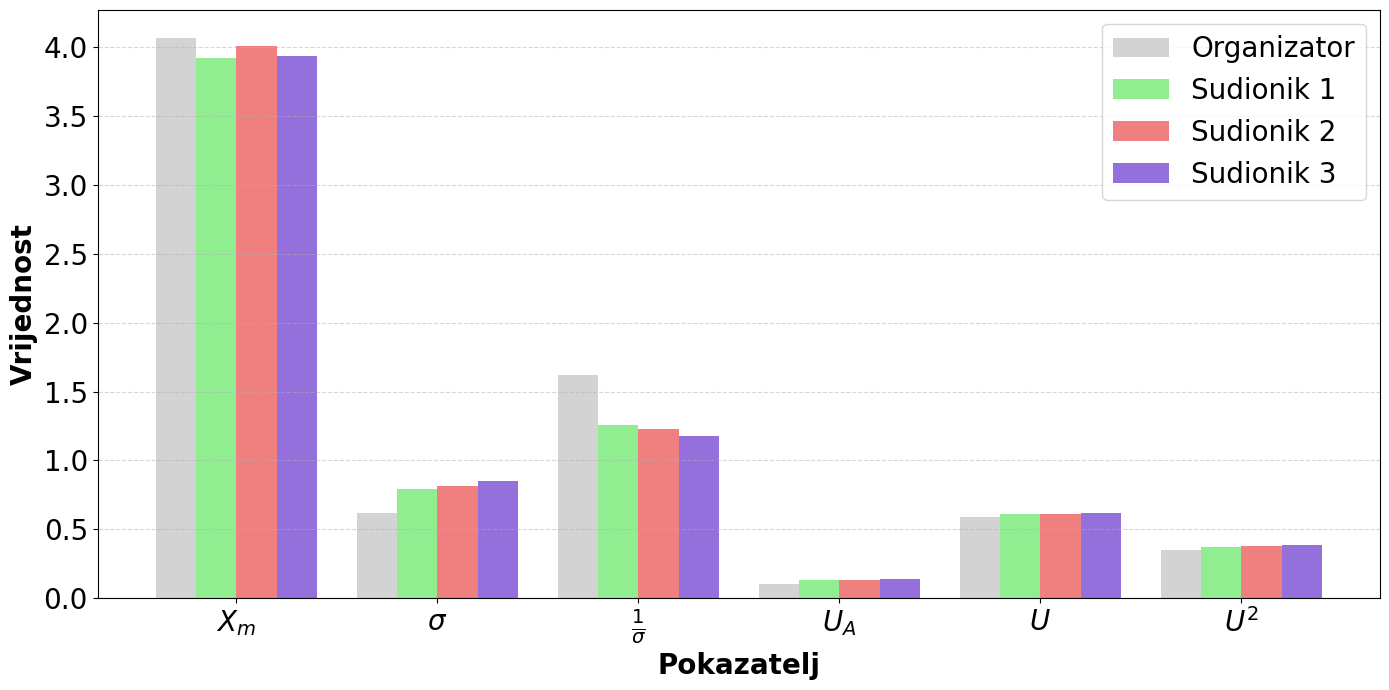

In [6]:
labels = ["$X_m$", r"$\sigma$", r"$\frac{1}{\sigma}$", r"$U_A$", r"$U$", r"$U^2$"]
org_values = [
    Xm_AV_org, sigma_AV_org, sigma_AV_inverse_org,
    U_A_AV_org, U_AV_org, U_AV_squared_org
]
p1_values = [
    Xm_MV_p1, sigma_MV_p1, sigma_MV_inverse_p1,
    U_A_MV_p1, U_MV_p1, U_MV_squared_p1
]
p2_values = [
    Xm_MV_p2, sigma_MV_p2, sigma_MV_inverse_p2,
    U_A_MV_p2, U_MV_p2, U_MV_squared_p2
]
p3_values = [
    Xm_MV_p3, sigma_MV_p3, sigma_MV_inverse_p3,
    U_A_MV_p3, U_MV_p3, U_MV_squared_p3
]

labels = ["$X_m$", r"$\sigma$", r"$\frac{1}{\sigma}$", r"$U_A$", r"$U$", r"$U^2$"]
org_values = [Xm_AV_org, sigma_AV_org, sigma_AV_inverse_org, U_A_AV_org, U_AV_org, U_AV_squared_org]
p1_values = [Xm_MV_p1, sigma_MV_p1, sigma_MV_inverse_p1, U_A_MV_p1, U_MV_p1, U_MV_squared_p1]
p2_values = [Xm_MV_p2, sigma_MV_p2, sigma_MV_inverse_p2, U_A_MV_p2, U_MV_p2, U_MV_squared_p2]
p3_values = [Xm_MV_p3, sigma_MV_p3, sigma_MV_inverse_p3, U_A_MV_p3, U_MV_p3, U_MV_squared_p3]

x = np.arange(len(labels))
width = 0.2

plt.figure(figsize=(14, 7))

plt.bar(x - 1.5 * width, org_values, width, label='Organizator', color='lightgrey')
plt.bar(x - 0.5 * width, p1_values, width, label='Sudionik 1', color='lightgreen')
plt.bar(x + 0.5 * width, p2_values, width, label='Sudionik 2', color='lightcoral')
plt.bar(x + 1.5 * width, p3_values, width, label='Sudionik 3', color='mediumpurple')

plt.xlabel('Pokazatelj', fontsize=20, fontweight='bold')
plt.ylabel('Vrijednost', fontsize=20, fontweight='bold')

plt.xticks(x, labels, fontsize=20)
plt.yticks(fontsize=20)

plt.legend(fontsize=20, loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("rezultati_predobrada_stilizirano.png", dpi=300, bbox_inches='tight')
plt.show()

Šifriranje

In [7]:
def encrypt_value(value):
    return ts.ckks_vector(context, [value])

Xm_MV_p1_enc = encrypt_value(Xm_MV_p1)
sigma_MV_p1_enc = encrypt_value(sigma_MV_p1)
sigma_MV_inverse_p1_enc = encrypt_value(sigma_MV_inverse_p1)
U_A_MV_p1_enc = encrypt_value(U_A_MV_p1)
U_MV_p1_enc = encrypt_value(U_MV_p1)
U_MV_squared_p1_enc = encrypt_value(U_MV_squared_p1)

Xm_MV_p2_enc = encrypt_value(Xm_MV_p2)
sigma_MV_p2_enc = encrypt_value(sigma_MV_p2)
sigma_MV_inverse_p2_enc = encrypt_value(sigma_MV_inverse_p2)
U_A_MV_p2_enc = encrypt_value(U_A_MV_p2)
U_MV_p2_enc = encrypt_value(U_MV_p2)
U_MV_squared_p2_enc = encrypt_value(U_MV_squared_p2)

Xm_MV_p3_enc = encrypt_value(Xm_MV_p3)
sigma_MV_p3_enc = encrypt_value(sigma_MV_p3)
sigma_MV_inverse_p3_enc = encrypt_value(sigma_MV_inverse_p3)
U_A_MV_p3_enc = encrypt_value(U_A_MV_p3)
U_MV_p3_enc = encrypt_value(U_MV_p3)
U_MV_squared_p3_enc = encrypt_value(U_MV_squared_p3)

Xm_AV_org_enc = encrypt_value(Xm_AV_org)
sigma_AV_org_enc = encrypt_value(sigma_AV_org)
sigma_AV_inverse_org_enc = encrypt_value(sigma_AV_inverse_org)
U_A_AV_org_enc = encrypt_value(U_A_AV_org)
U_AV_org_enc = encrypt_value(U_AV_org)
U_AV_squared_org_enc = encrypt_value(U_AV_squared_org)

Funkcija za provođenje dijeljenja N-R algoritmom

In [8]:
def approx_inv_en(enc_x, U_MV_squared , iterations=3):
    
    x0 = 0.67/(1.5*U_MV_squared)
    y = ts.ckks_vector(enc_x.context(), [1 / x0])

    for i in range(iterations):
        y = y * (2 - enc_x * y)

    return y

Funkcija za provođenje izračuna z i En vrijednosti

In [9]:
def izracunaj_z_i_En(Xm_MV_enc, Xm_AV_enc, sigma_inverse_enc, U_MV_squared_enc, U_AV_squared_enc, U_MV_squared):

    # sudionik
    delta_X_enc = Xm_MV_enc - Xm_AV_enc

    z_enc = delta_X_enc * sigma_inverse_enc

    # organizator
    U_sum_enc = U_MV_squared_enc + U_AV_squared_enc

    U_sum_enc_inv = approx_inv_en(U_sum_enc, U_MV_squared)
    
    En_enc = ((delta_X_enc)**2) * U_sum_enc_inv

    return z_enc, En_enc


Primjena funkcije za provođenje izračuna z i En vrijednosti
i računanje vremena izvođenja

In [10]:
broj_ponavljanja = 3
vremena = []

for _ in range(broj_ponavljanja):
    
    gc.collect()
    start = time.perf_counter()

    z_p1, En_p1 = izracunaj_z_i_En(
        Xm_MV_p1_enc, Xm_AV_org_enc,
        sigma_MV_inverse_p1_enc,
        U_MV_squared_p1_enc, U_AV_squared_org_enc,
        U_MV_squared_p1
    )

    z_p2, En_p2 = izracunaj_z_i_En(
        Xm_MV_p2_enc, Xm_AV_org_enc,
        sigma_MV_inverse_p2_enc,
        U_MV_squared_p2_enc, U_AV_squared_org_enc,
        U_MV_squared_p2
    )

    z_p3, En_p3 = izracunaj_z_i_En(
        Xm_MV_p3_enc, Xm_AV_org_enc,
        sigma_MV_inverse_p3_enc,
        U_MV_squared_p3_enc, U_AV_squared_org_enc,
        U_MV_squared_p3
    )

    end = time.perf_counter()
    trajanje = end - start
    vremena.append(trajanje)

if len(vremena) > 1:
    vremena = vremena[1:]

if vremena:
    prosjek = sum(vremena) / len(vremena)
    print(f"Prosječno trajanje (bez warm-up): {prosjek:.6f} sekundi")
else:
    print("Nema dovoljno uspješnih mjerenja za izračun prosjeka.")
    

Prosječno trajanje (bez warm-up): 25.746725 sekundi


Dešifriranje

In [11]:
z_p1_dec = z_p1.decrypt()[0]
En_p1_dec = En_p1.decrypt()[0]
print(En_p1_dec)
En_p1 = math.sqrt(np.abs(En_p1_dec))

z_p2_dec = z_p2.decrypt()[0]
En_p2_dec = En_p2.decrypt()[0]
En_p2 = math.sqrt(np.abs(En_p2_dec))

z_p3_dec = z_p3.decrypt()[0]
En_p3_dec = En_p3.decrypt()[0]
En_p3 = math.sqrt(np.abs(En_p3_dec))

print("Rezultati za participant1:")
print("z =", z_p1_dec)
print("E_n =", En_p1)

print("\nRezultati za participant2:")
print("z =", z_p2_dec)
print("E_n =", En_p2)

print("\nRezultati za participant3:")
print("z =", z_p3_dec)
print("E_n =", En_p3)

with open(f"z_i_En_rezultati__{poly_mod_degree}_{coeff_mod_bit_sizes}_{scale}.txt", "w", encoding="utf-8") as file:
    file.write("Rezultati za participant1:\n")
    file.write(f"z = {z_p1_dec:.6f}\n")
    file.write(f"E_n = {En_p1:.6f}\n\n")

    file.write("Rezultati za participant2:\n")
    file.write(f"z = {z_p2_dec:.6f}\n")
    file.write(f"E_n = {En_p2:.6f}\n\n")

    file.write("Rezultati za participant3:\n")
    file.write(f"z = {z_p3_dec:.6f}\n")
    file.write(f"E_n = {En_p3:.6f}\n\n")

    file.write("end\n")

0.02872489074654532
Rezultati za participant1:
z = -0.18076826692443015
E_n = 0.16948419025544925

Rezultati za participant2:
z = -0.07510996617820866
E_n = 0.07171190501431453

Rezultati za participant3:
z = -0.1512991163627318
E_n = 0.15037741561363732


Prikaz dobivenih z i En vrijednosti

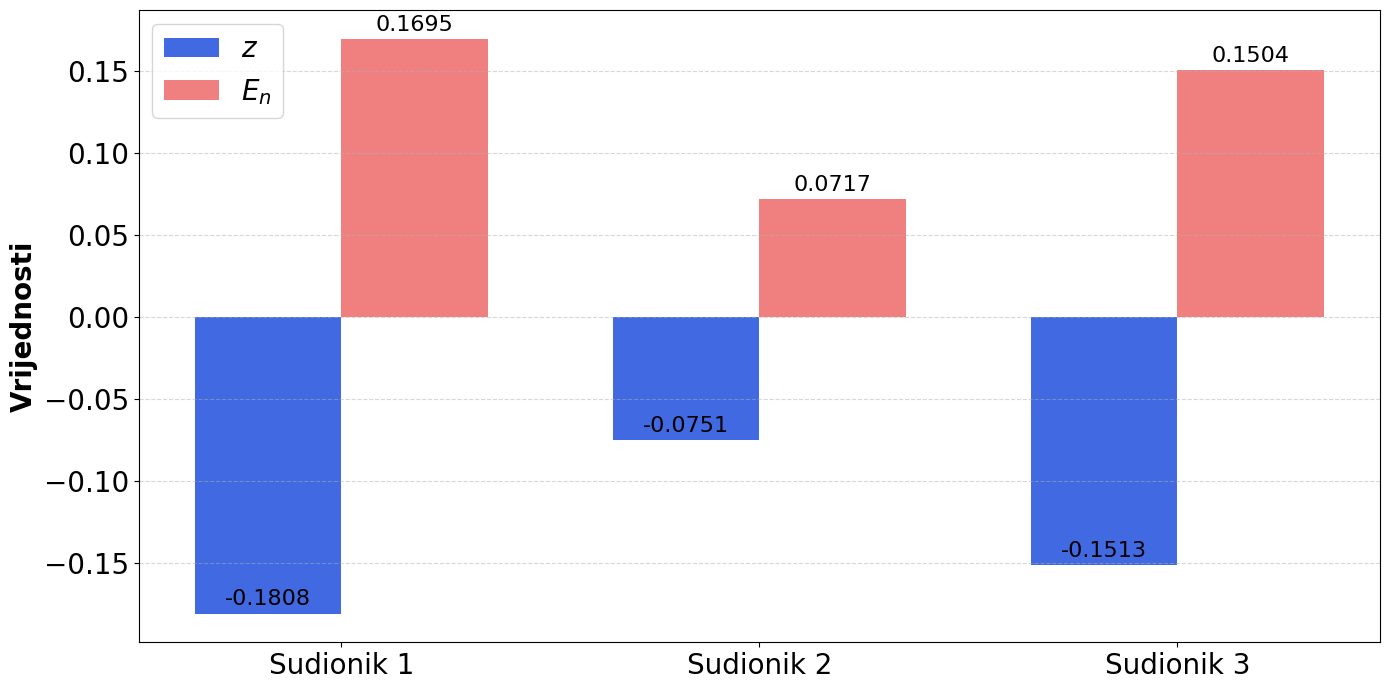

In [12]:
participants = ['Sudionik 1', 'Sudionik 2', 'Sudionik 3']
z_values = [z_p1_dec, z_p2_dec, z_p3_dec]
En_values = [En_p1, En_p2, En_p3]

x = np.arange(len(participants))
width = 0.35

plt.figure(figsize=(14, 7))

bars1 = plt.bar(x - width/2, z_values, width, label=r'$z$', color='royalblue')
bars2 = plt.bar(x + width/2, En_values, width, label=r'$E_n$', color='lightcoral')

# Osi
plt.ylabel('Vrijednosti', fontsize=20, fontweight='bold')

plt.xticks(x, participants, fontsize=20)
plt.yticks(fontsize=20)

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(fontsize=20, loc='best')

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.4f}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=16)

add_labels(bars1)
add_labels(bars2)

plt.tight_layout()
plt.savefig(f"pokazatelji_sudionici__{poly_mod_degree}_{coeff_mod_bit_sizes}_{scale}.png", dpi=300, bbox_inches='tight')
plt.show()

Unos vrijednosti dobivenih za jedno izvođenje i referentnih vrijednosti
(dobivene ručnim proračunom)

In [13]:
z_p1 = [-0.182024,	-0.180785,	-0.180769, -0.180768,	-0.181731,	-0.180807,	-0.180769,	-0.180768,	-0.180768,	-0.180768
] 
z_p2 = [-0.075691,	-0.075114,	-0.075111,	-0.075110,	-0.075553,	-0.075128,	-0.075111,	-0.075110,	-0.075110,	-0.075110
]
z_p3 = [-0.152246,	-0.151307,	-0.151300,	-0.151299,	-0.152676,	-0.151334,	-0.151301,	-0.151299,	-0.151299,	-0.151299
]

en_p1 = [-0.176690,	-0.169713,	-0.169492,	-0.169484,	-0.182022,	-0.169999,	-0.169498,	-0.169484,	-0.169483,	-0.169483
] 
en_p2 = [-0.074665,	-0.071783,	-0.071716,	-0.071712,	-0.073541,	-0.071940,	-0.071712,	-0.071712,	-0.071712,	-0.071712
]
en_p3 = [-0.155743,	-0.150580,	-0.150383,	-0.150377,	-0.162690,	-0.150833,	-0.150391,	-0.150378,	-0.150377,	-0.150377
]

z_ref_p1 = [-0.233031]
z_ref_p2 = [-0.098782]
z_ref_p3 = [-0.208052]

en_ref_p1 = [-0.169536]
en_ref_p2 = [-0.071731]
en_ref_p3 = [-0.150040]


Funkcija za izračun relativne pogreške

In [14]:
def relative_error(values, reference):
    values = np.array(values)
    return np.abs((values - reference) / reference)

Izračun i prikaz relativnih pogrešaka po segmentima

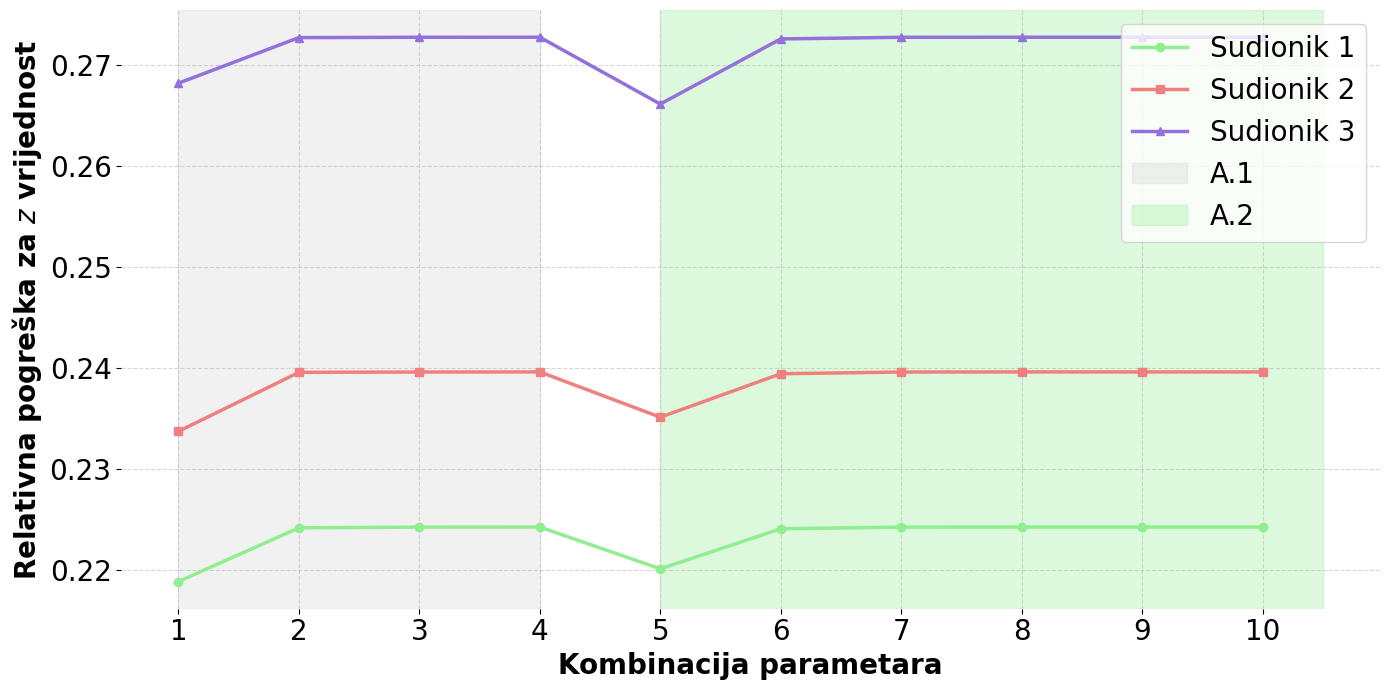

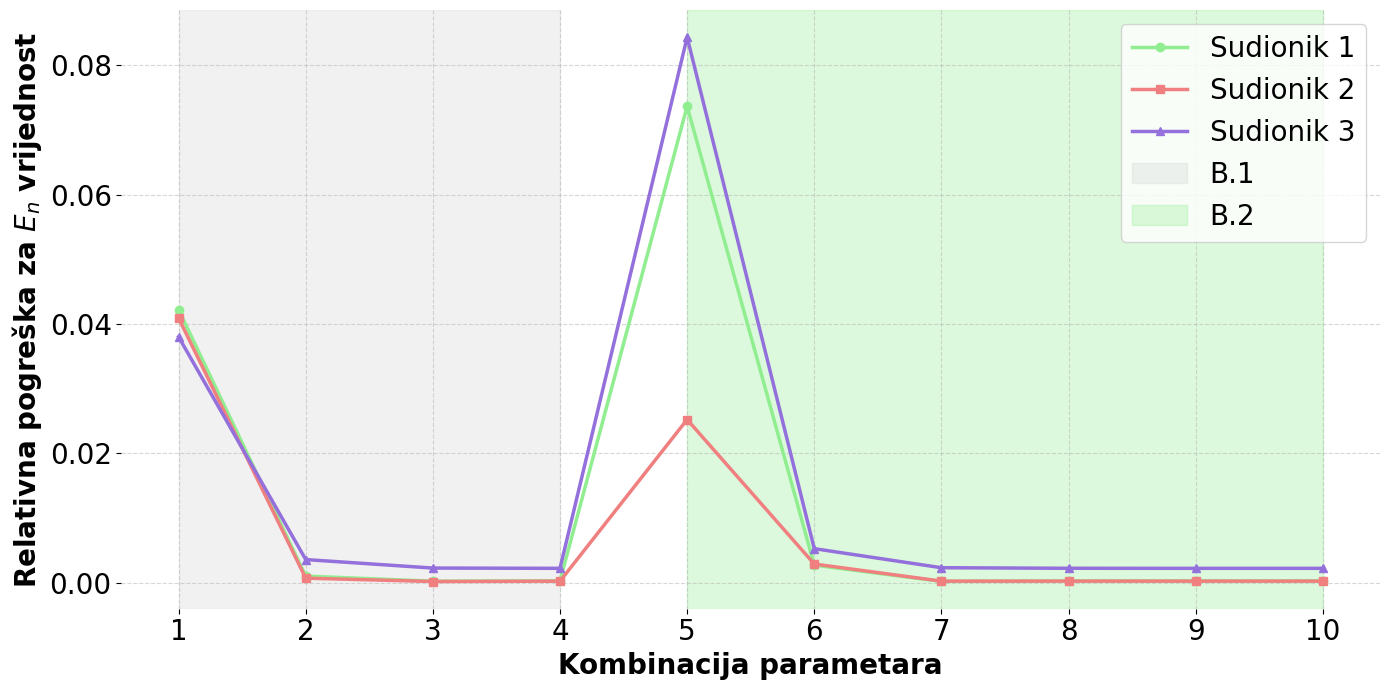

In [15]:
rel_err_z_p1 = relative_error(z_p1, z_ref_p1)
rel_err_z_p2 = relative_error(z_p2, z_ref_p2)
rel_err_z_p3 = relative_error(z_p3, z_ref_p3)

rel_err_en_p1 = relative_error(en_p1, en_ref_p1)
rel_err_en_p2 = relative_error(en_p2, en_ref_p2)
rel_err_en_p3 = relative_error(en_p3, en_ref_p3)

x = np.arange(1, 11)
x_labels = [str(i) for i in x]

plt.figure(figsize=(14, 7))

plt.plot(x, rel_err_z_p1, marker='o', linestyle='-', linewidth=2.5,
         color='lightgreen', label='Sudionik 1')
plt.plot(x, rel_err_z_p2, marker='s', linestyle='-', linewidth=2.5,
         color='lightcoral', label='Sudionik 2')
plt.plot(x, rel_err_z_p3, marker='^', linestyle='-', linewidth=2.5,
         color='mediumpurple', label='Sudionik 3')

plt.axvspan(1, 4, color='lightgrey', alpha=0.3, label="A.1")
plt.axvspan(5, 10.5, color='lightgreen', alpha=0.3, label="A.2")

plt.xlabel("Kombinacija parametara", fontsize=20, fontweight='bold')
plt.ylabel("Relativna pogreška za $z$ vrijednost", fontsize=20, fontweight='bold')

plt.xticks(x, x_labels, fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True, linestyle='--', alpha=0.5)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize=20, loc='upper right')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.tight_layout()
plt.savefig("sol2_relativna_pogreska_z.png", dpi=300)
plt.show()

plt.figure(figsize=(14, 7))

plt.plot(x, rel_err_en_p1, marker='o', linestyle='-', linewidth=2.5,
         color='lightgreen', label='Sudionik 1')
plt.plot(x, rel_err_en_p2, marker='s', linestyle='-', linewidth=2.5,
         color='lightcoral', label='Sudionik 2')
plt.plot(x, rel_err_en_p3, marker='^', linestyle='-', linewidth=2.5,
         color='mediumpurple', label='Sudionik 3')

plt.axvspan(1, 4, color='lightgrey', alpha=0.3, label="B.1")
plt.axvspan(5, 10, color='lightgreen', alpha=0.3, label="B.2")

plt.xlabel("Kombinacija parametara", fontsize=20, fontweight='bold')
plt.ylabel("Relativna pogreška za $E_n$ vrijednost", fontsize=20, fontweight='bold')

plt.xticks(x, x_labels, fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True, linestyle='--', alpha=0.5)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize=20, loc='best')

for spine in plt.gca().spines.values():
    spine.set_visible(False)
    
plt.tight_layout()
plt.savefig("sol2_relativna_pogreska_en.png", dpi=300)
plt.show()


Unos vrijednosti vremena izvođenja i prikaz za sve kombinacije parametara

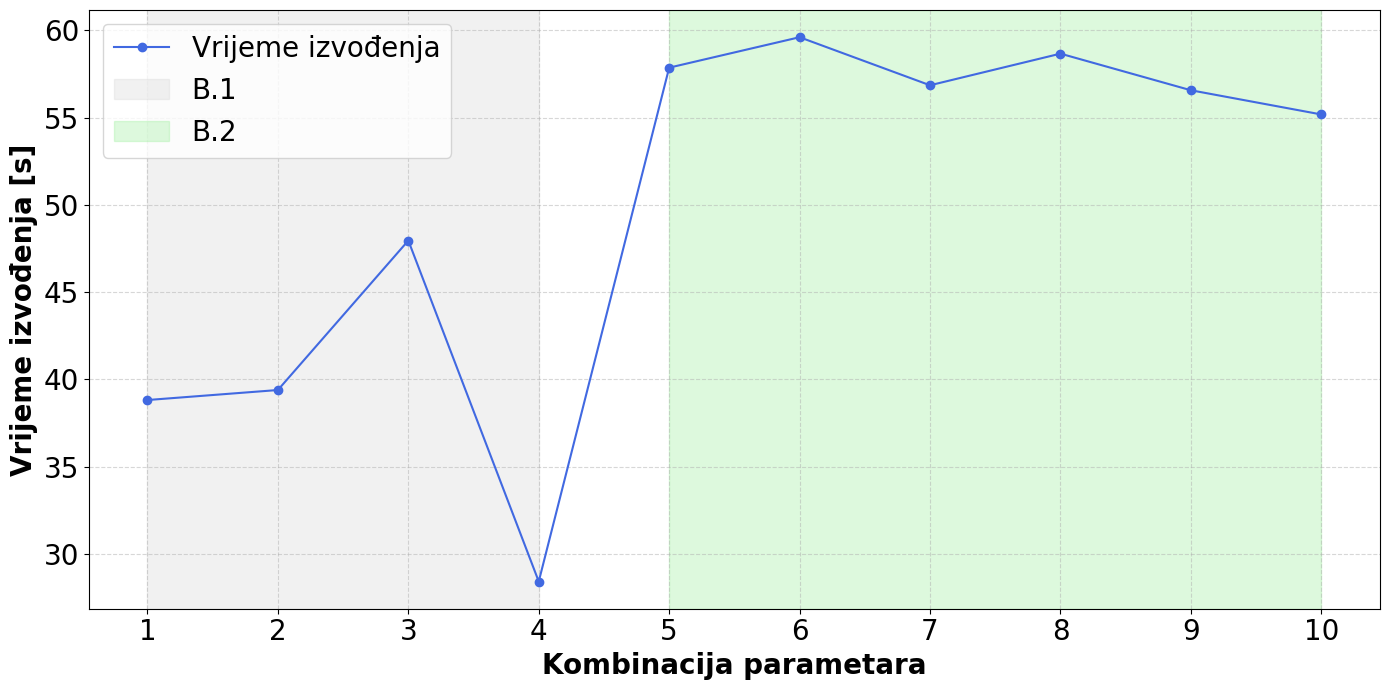

In [16]:
vrijeme_s = [38.821970, 39.395483, 47.956235, 28.427608, 57.858437, 59.602575, 56.849671, 58.661744, 56.564112, 55.178663] 

x = list(range(1, len(vrijeme_s) + 1))

plt.figure(figsize=(14, 7))
plt.plot(x, vrijeme_s, marker='o', linestyle='-', color='royalblue', label="Vrijeme izvođenja")

plt.axvspan(1, 4, color='lightgrey', alpha=0.3, label="B.1")
plt.axvspan(5, 10, color='lightgreen', alpha=0.3, label="B.2")

plt.xlabel("Kombinacija parametara", fontsize=20, fontweight='bold')
plt.ylabel("Vrijeme izvođenja [s]", fontsize=20, fontweight='bold')

plt.xticks(x, fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True, linestyle='--', alpha=0.5)

plt.legend(fontsize=20, loc='upper left')

plt.tight_layout()
plt.savefig("vrijeme_izvodenja_sol2.png", dpi=300) 
plt.show()
